In [91]:
# Julia version code
"""
nonnegative linear regression 
"""

# Notes
# 1. Note we set min A_ij = 1. This can be done either by dividing A by min Aij or by just adding 1. 
# The first approach is kind of cheating because the scaling automatically makes the error small
# If min Aij is not 1, then init error can be LARGE 

#2. If all xj coordinates are updated in parallel, then comparable to scipy (update_v_parllel and update_X_paralle)

#3. If coordinatewise update, then scaling down by n is better than not scaling. 

#4. Our theoreitcal alg in experiment has occasional large jumps in error

#5. The init large error issue is fixed by running a full update step first

#6. x is very very very sparse

#7. TODO m << n case 

#import Pkg; Pkg.add("Plots")
using LinearAlgebra, BenchmarkTools, Distributions, Plots

const MultivariateDistribution{S<:ValueSupport} = Distribution{Multivariate,S}

const DiscreteMultivariateDistribution   = Distribution{Multivariate, Discrete}
const ContinuousMultivariateDistribution = Distribution{Multivariate, Continuous}

function compute_scaling(A)
    scaling_vector = -1 ./sum(abs2.(A),dims=1)
    return scaling_vector
end

function init_all(epsilon, m, n, A)
    ktotal = Int(ceil(n/sqrt(epsilon))) #note that this is just an approx ktotal
    
    akm = 1/n 
    Akm = 1/n
    ak = 1/n^2
    Ak = (1+n)/n^2
    
    scaling_vector = compute_scaling(A) 
    
    randomseed=rand(Multinomial(1, ones(n)/n),1)
    jk = findall(vec(randomseed.==1))[1] #
    
    v = zeros(n) # vector with same length as x, used to obtain x
    v[jk]=-1 
    xkm = zeros(n) 
    xkm[jk]=-1/scaling_vector[jk] #xkm = x_1
    
    ykm = A*xkm # ykm = y_1 
    xtildek = xkm # wildtilde{x_k}
    ybar = (n+1)*ykm # ybar = ybar_1
    
    return ybar, ykm, xtildek, ktotal, ak, akm, Ak, Akm, v, xkm, scaling_vector
end

function update_v(jk, A, ybar, v, ak) 
    v[jk]+= n*ak*(dot(A[:,jk],ybar) - 1) # ybar = ybar_{k-1}
    return v
end

function update_x(v, jk, xkm, scaling) 
    x = xkm
    x[jk]= min(max(scaling*v[jk], 0),-scaling) # n has appeared in v
    return x      
end

function update_y(n, ak, Ak, Akm, x, xkm, xtildek, A)
    xtildek = (Akm/Ak)*xtildek+(n*ak/Ak)*x-((n-1)*ak/Ak)*xkm
    y =  A*xtildek
    return xtildek, y
end

function update_ak_Ak(Ak, Akm, ak, akm, n) 
    akm = ak
    ak = min(n*ak/(n-1),sqrt(Ak)/(2*n))
    Akm = Ak
    Ak = Ak+ ak
    return Ak, Akm, ak, akm
end

function update_ybar(y, ykm, ak, akm)
    ybar = y + (akm/ak)*(y - ykm)
    return ybar 
end



function remove_col1(A,b)
    s=A'*b # n*1 
    B=A[:,vec(s.>0)] # m*b matrix where b is smaller than n
    s=s[vec(s.>0)] # s is b*1
    A=B./s'
    return A, B, s
end

remove_col1 (generic function with 1 method)

1.1039891075811665f = Plot{Plots.GRBackend() n=1}


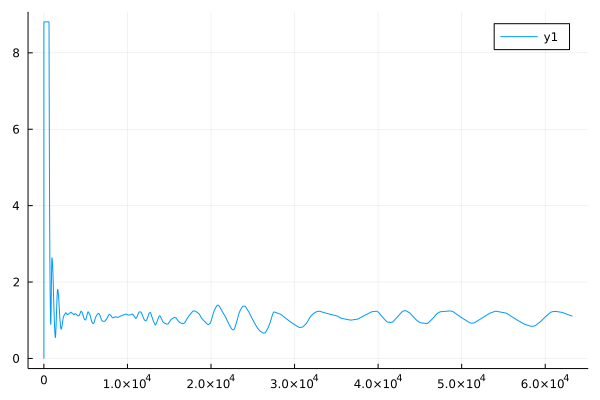

In [97]:
# Main loop
epsilon = 0.00001 
n = 200 # input dimension 
m = 20 # Number of data 

# b can also be random and negative. m<<n.
b=rand(m,1)-repeat([0.3],m,1)
A=rand(m,n)

(A,B,s)=remove_col1(A,b)

(m,n)=size(A) # Redefine the size number n and m to prevent triviality.

(ybar, ykm, xtildek, ktotal, ak, akm, Ak, Akm, v, xkm, scaling_vector) = init_all(epsilon, m, n, A)
our_result = zeros(ktotal)    

for k in 2:ktotal 
        # sample jk from multinomial distribution
        randomseed=rand(Multinomial(1, ones(n)/n),1)
        jk = findall(vec(randomseed.==1))[1] # 
        
        # # update v 
        v = update_v(jk, A, ybar, v, ak) 
        
        # update x
        x = update_x(v, jk, xkm, scaling_vector[jk])
        
        # Update y based on u
        (xtildek, y) = update_y(n, ak, Ak, Akm, x, xkm, xtildek, A)
    
        #update a 
        (Ak, Akm, ak, akm) = update_ak_Ak(Ak, Akm, ak, akm, n)
    
        #update ybar 
        ybar = update_ybar(y, ykm, ak, akm)
     
        # update xkm 
        xkm = x 
        
        our_result[k] = norm(A*xtildek)^2/2-sum(xtildek)
        #our_result[k] = norm(A.dot(y),2)**2/2-sum(xsol_temp)
end

our_result1= xtildek
print(norm(A*our_result1)^2/2-sum(our_result1))

f = plot(our_result)
@show f

In [89]:
v

200-element Array{Float64,1}:
 2772.8544124683035
 2029.358674064732
  383.676775535034
 7313.821573072745
 5823.321047576383
 3151.350542135955
 3727.0924424402237
 1351.1163973265413
 4263.9104974051415
 2424.803277152037
 1555.459754091909
 1536.36081072718
 2515.684266526049
    ⋮
 1839.800775662678
  656.0565380277127
 3373.1608045028293
 5430.595799066984
 2063.2698047010185
  -11.818340594496394
 1874.467758545668
 4551.690282414851
 5658.174875907087
  760.3302391761177
 2240.5226644104137
 1286.1151229770924